# Python for Investment Portfolio

## 1. 變數

在Python中，您可以將值賦給變數。您可以將Python中的變數視為存儲值的容器。與其他編程語言不同，Python在使用變數之前不需要定義它。

以下示例創建了兩個變數`a`和`b`，分別存儲值`3`和`4`，並將它們的和存儲在一個名為`sum`的變數中。

In [2]:
a = 3
b = 4

sum = a + b

print(sum)

7


## 2. 縮排

縮排和間距對Python來說很重要。Python使用縮排來表示一個代碼塊。你不應該隨意在代碼中添加前置空格。

以下代碼是正確的：
```
a = 3
b = 4
c = a + b
```
以下代碼會返回錯誤：
```
a = 3
b = 4
    c = a + b
```
現在輪到你了！請試試以下代碼：

In [3]:
# 嘗試添加前置空格以查看效果

a = 3
b = 4
c = a + b

## 3. 從 Yahoo! Finance獲取數據

Python 提供了很多有用的庫，可用於執行不同的功能。在此工作坊中，我們將使用 `yfinance` 套件，該套件不是預設安裝的，需要手動安裝。

## 安裝不在Colaboratory內的套件

若要安裝Colaboratory不提供的套件，我們使用以下命令：

`!pip install <<套件庫名>>`

`yfinance`套件提供了一種從Yahoo! Finance下載歷史市場數據的方法。您可以在[此處](https://pypi.org/project/yfinance/)獲取`yfinance`項目的詳細信息。

由於`yfinance`不是Colab中的默認包，因此需要手動安裝。

`!pip install yfinance`

In [ ]:
!pip install yfinance

### 獲取股票數據
現在，讓我們從2022年3月31日到2023年4月1日獲取“騰訊”的股票數據

In [5]:
import yfinance as yf

ticker = "0700.HK"
start = "2022-03-31"
end = "2023-04-01"

data = yf.download(ticker, start, end)

data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-31,382.399994,382.399994,372.600006,374.200012,372.448334,14589554
2022-04-01,367.000000,378.799988,362.200012,378.799988,377.026794,14496674
2022-04-04,388.799988,391.000000,383.799988,390.000000,388.174377,15665556
2022-04-06,383.000000,385.000000,380.000000,381.000000,379.216492,17127923
2022-04-07,375.600006,383.600006,373.799988,374.399994,372.647400,15874056


### 現在，讓我們計算該股票的日回報率。
我們可以使用`pandas`提供的`pct_change()`函數計算日、月或年回報率。

In [6]:
data["Adj Close"].pct_change(1)  # 1 is for daily, 21 is for monthly, 252 is for annually.

Date
2022-03-31         NaN
2022-04-01    0.012293
2022-04-04    0.029567
2022-04-06   -0.023077
2022-04-07   -0.017323
                ...   
2023-03-27   -0.037155
2023-03-28    0.042448
2023-03-29    0.017451
2023-03-30    0.000520
2023-03-31    0.002078
Name: Adj Close, Length: 247, dtype: float64

### 創建另一個 dataframe 來存儲所需的列

In [8]:
import pandas as pd

stock = pd.DataFrame()
stock['Price'] = data["Adj Close"]
stock['Return'] = data['Adj Close'].pct_change(1)
stock = stock.dropna()
stock.head()

,Price,Return
Date,,
2022-04-01,377.026794,0.012293
2022-04-04,388.174377,0.029567
2022-04-06,379.216492,-0.023077
2022-04-07,372.647400,-0.017323
2022-04-08,367.869873,-0.012821


### 現在，繪製該股票的股價圖表以查看。

<AxesSubplot:xlabel='Date'>

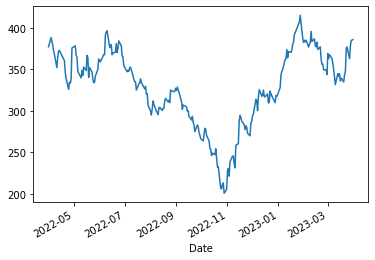

In [9]:
stock['Price'].plot()

# 4. 構建投資組合

### 接下來，我們將使用2個或多個股票創建一個投資組合。某些代碼可能比較困難，但請直接執行它，我們稍後會對其進行解釋。

### 以下代碼提供了創建和可視化投資組合構建的基本功能，請直接執行該單元格。

In [60]:
import pandas as pd
import numpy as np
import yfinance as yf
import math
import scipy.optimize as sco
import matplotlib.ticker as mtick



def get_data_from_yahoo(ticker, from_yahoo=True, start = start_date, end= end_date):

    column_price_name = ticker + ".P"
    column_return_name = ticker + ".R"
    

    data = yf.download(ticker, start, end)
    stock = pd.DataFrame()
    stock[column_price_name] = data['Adj Close']
    stock[column_return_name] = data['Adj Close'].pct_change(1)
    stock = stock.dropna()
            
    return stock

def get_stocks(tickers, from_yahoo=True, start= start_date, to= end_date):
    df_list =[]
    for ticker in tickers:
        df_list.append(get_data_from_yahoo(ticker, from_yahoo, start =start_date, end= end_date))
    
    return_df = pd.concat(df_list, axis=1, join='inner')
    return_df['Date'] = return_df.index.to_frame()
    return return_df

def expected_return(tickers, df):
    mean = pd.Series(np.zeros(len(tickers)), index=tickers)
    sd = pd.Series(np.zeros(len(tickers)), index=tickers)
    data = {
        "Mean": mean,
        "SD": sd
    }
    return_df = pd.DataFrame(data)
    
    for ticker in tickers:
        col_name = ticker + ".R"
        return_df.loc[ticker]['Mean'] = df[col_name].mean() * 250 #annualize
        return_df.loc[ticker]['SD'] = df[col_name].std()
        
    
    return return_df

def cal_cov(tickers, df):
    return_df = pd.DataFrame()
    for ticker in tickers:
        col_name = ticker + ".R"
        return_df[ticker] = df[col_name]
    
    return return_df.cov()

def cal_portfolio_performance(weights, returns, covmat):
    returns = np.sum(weights*returns)
    std = np.sqrt(np.dot(weights.T, np.dot(covmat, weights)))
    return returns, std
    
def gen_portfolio(num_portfolio, returns, covmat, rf_rate):
    results = np.zeros((3, num_portfolio))
    weights_record = []
    for i in range(num_portfolio):
        weights = np.random.random(len(returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        p_ret, p_std = cal_portfolio_performance(weights, returns, covmat)
        results[0,i] = p_ret
        results[1,i] = p_std
        results[2,i] = (p_ret -rf_rate)/p_std
    return results, weights_record

def efficient_return(returns, cov_mat, target):
    num_assets = len(returns)
    args = (returns, cov_mat)
    
    def portfolio_return(weights):
        return cal_portfolio_performance(weights, returns, cov_mat)[0]
    
    def portfolio_volatility(weights, returns, cov_mat):
        return cal_portfolio_performance(weights, returns, cov_mat)[1]
    
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    bounds = tuple((0,1) for asset in range(num_assets))
    results = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return results

def efficient_frontier(returns, covmat, returns_range):
    efficients=[]
    for ret in returns_range:
        efficients.append(efficient_return(returns, covmat, ret))
    return efficients

def form_portfolio(tickers, stock_df, show_frontier, num_portfolio):
    import plotly.graph_objects as go

    assets = expected_return(tickers, stocks_df)
    cov_mat = cal_cov(tickers, stocks_df)

    results, weights = gen_portfolio(num_portfolio, assets['Mean'], cov_mat, 0)
    
    # optimal portfolio
    max_sharpe_idx = np.argmax(results[2])
    ret_max, std_max = results[0, max_sharpe_idx], results[1, max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=tickers,columns=['allocation'])
    
    
    # min var portfolio
    min_vol_idx = np.argmin(results[1])
    ret_min, std_min = results[0, min_vol_idx], results[1, min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=tickers,columns=['allocation'])
    
    min_ret_idx = np.argmin(results[0])
    max_ret_idx = np.argmax(results[0])
    
    min_ret = results[0, min_ret_idx]
    max_ret = results[0, max_ret_idx]
    
    
    
    fig = go.Figure()

    cap_text_series = pd.Series([], dtype= 'string')
    cap_text_optimal = []
    cap_text_vol = []

    for i in range(len(weights)):
        cap_text = ""
        for j in range(len(tickers)):
            c_text = "{} weights: {}; ".format(tickers[j], "{}%".format(np.round(weights[i][j]*100, 2)))
            cap_text += c_text     
        cap_text_series = pd.concat([cap_text_series, pd.Series([cap_text])], ignore_index=True)
       
        if i == max_sharpe_idx:
            cap_text_optimal = [cap_text]
        if i == min_vol_idx:
            cap_text_vol = [cap_text]



    fig.add_trace(go.Scatter(x=results[1,:], y=results[0,:],
                        mode='markers', name='Other Portfolios', 
                             marker=dict(color='LightSkyBlue', size=6), text=cap_text_series))
    
    fig.add_trace(go.Scatter(x=[std_max], y=[ret_max], mode='markers', name='Optimal portfolio', 
                             marker=dict(color='red', size=10), text=cap_text_optimal ))

    fig.add_trace(go.Scatter(x=[std_min], y=[ret_min], mode='markers', name='Min. var portfolio', 
                             marker=dict(color='green', size=10), text=cap_text_vol ))

    if show_frontier:
        target = np.linspace(ret_min, max_ret, 50)
        efficient_portfolios = efficient_frontier(assets['Mean'], cov_mat, target)
        fig.add_trace(go.Scatter(x=[p['fun'] for p in efficient_portfolios], y=target, name='Efficient Frontier', 
                             marker=dict(color='black', size=8) ))
        
    layout = go.Layout(title="Efficient Frontier", xaxis=dict(title="S.D.", tickformat=".2%"), yaxis=dict(title="Expected Return", tickformat=".2%"))
    fig.layout = layout
    fig.show()
    
    return max_sharpe_allocation

    
def plot_stocks(stock):
    import plotly.express as px

    fig = px.line(stock, x="Date", y='Price', color="Stock", facet_col="Stock", facet_col_wrap=2)
    fig.update_yaxes(matches=None)
    fig.update_yaxes(showticklabels=True)
    fig.show()

    
def pie_chart(optimal_p):
    import plotly.graph_objects as go
    colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
    labels = optimal_p.T.columns.to_list()
    values = optimal_p.T.iloc[0].to_list()
    fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent',
                             insidetextorientation='radial'
                            )])
    fig.update_traces(hoverinfo='label+percent', textinfo='label+percent', textfont_size=18,
                  marker=dict(colors=colors, line=dict(color='#000000', width=1)))
    fig.show()

### 我們選擇了三種股票，並要求 Python 模擬2000個不同投資組合。

In [115]:
start_date = "2022-03-31"
end_date = "2023-04-01"

tickers = ['0005.HK', '0066.HK','0700.HK']
stocks_df = get_stocks(tickers, True, start_date, end_date )

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [118]:
optimal_p = form_portfolio(tickers, stocks_df, True, 2000)

### 最後，讓我們展示如何構建最優投資組合。

In [117]:
pie_chart(optimal_p)